Imports

In [1]:
from typing import Tuple, List
import cv2
import numpy as np
from skimage import measure
from matplotlib import pyplot as plt
from skimage import feature

Median Filter, for applying Median Filter over the given point

In [2]:
def median_filter(img: np.ndarray, point: np.ndarray, filter_size: int) -> List:

    # Getting all the indices in the kernel around the given point
    indices = [[x, y]
               for x in range(point[1] - filter_size // 2, point[1] + filter_size // 2 + 1) 
               for y in range(point[0] - filter_size // 2, point[0] + filter_size // 2 + 1)]


    indices = list(filter(lambda x: not (x[0] < 0 or x[1] < 0 or x[0] >= img.shape[0] or x[1] >= img.shape[1]), indices))

    pixel_values = [0, 0, 0]

    # Find the median of pixel values for each colour
    for channel in range(3): pixel_values[channel] = list(img[index[0], index[1], channel] for index in indices)

    pixel_values = list(np.median(pixel_values, axis=1))

    # Returning the pixel values having median colour
    return pixel_values

Applies median filtering on given contour pixels, with the given filter size

In [3]:
def edge_median_filter(img: np.ndarray, contours_list: tuple, filter_size: int = 7) -> np.ndarray:
    temp_img = np.copy(img)

    for partition in contours_list:
        for point in partition:
            temp_img[point[0][1]][point[0][0]] = median_filter(img, point[0], filter_size)

    return cv2.cvtColor(temp_img, cv2.COLOR_HSV2RGB)

For displaying the different regions identified and the results of their Correction

In [4]:
def display_region(org_image: np.ndarray, shadow_clear_image: np.ndarray, label: int, label_region: np.ndarray, contours: tuple) -> None:
    
    # Cutting out shadow from the Image
    reverse_mask = cv2.cvtColor(cv2.bitwise_not(label_region), cv2.COLOR_GRAY2RGB)
    img_w_hole = org_image & reverse_mask

    # Using Temporary 
    temp_filter = cv2.cvtColor(label_region, cv2.COLOR_GRAY2RGB)
    cv2.drawContours(temp_filter, contours, -1, (255, 0, 0), 3)

    fig, axes = plt.subplots(2, 2)

    ax = axes.ravel()

    plt.title(f"Shadow Region {label}")

    ax[0].imshow(org_image)
    ax[0].set_title("Original Image")

    ax[1].imshow(temp_filter)
    ax[1].set_title("Shadow Region")

    ax[2].imshow(img_w_hole)
    ax[2].set_title("Shadow Region Cut")

    ax[3].imshow(shadow_clear_image)
    ax[3].set_title("Corrected Image")

    plt.tight_layout()
    plt.show()

Correcting the colours of the pixels inside the shadow region by doing linear transformation

In [5]:
def correct_region_lab(org_img: np.ndarray, shadow_clear_img: np.ndarray, shadow_indices: np.ndarray, non_shadow_indices: np.ndarray) -> np.ndarray:

    # Q: Rather than asking for RGB constants individually, why not adjust L only?
    # A: L component isn't enough to REVIVE the colors that were under the shadow.

    # Calculate average LAB values in current shadow region and non-shadow areas
    shadow_average_lab = np.mean(org_img[shadow_indices[0], shadow_indices[1], :], axis=0)

    # Get the average LAB from border areas
    border_average_lab = np.mean(org_img[non_shadow_indices[0], non_shadow_indices[1], :], axis=0)

    # Calculate ratios that are going to be used on clearing the current shadow region
    # This is different for each region, therefore calculated each time
    lab_ratio = border_average_lab / shadow_average_lab

    shadow_clear_img = cv2.cvtColor(shadow_clear_img, cv2.COLOR_RGB2LAB)
    shadow_clear_img[shadow_indices[0], shadow_indices[1]] = np.uint8(shadow_clear_img[shadow_indices[0], shadow_indices[1]] * lab_ratio)
    shadow_clear_img = cv2.cvtColor(shadow_clear_img, cv2.COLOR_LAB2RGB)

    return shadow_clear_img

def correct_region_rgb(org_img: np.ndarray, shadow_clear_img: np.ndarray, shadow_indices: np.ndarray, non_shadow_indices: np.ndarray) -> np.ndarray:

    # Calculate average BGR values in current shadow region and non-shadow areas
    shadow_average_rgb = np.mean(org_img[shadow_indices[0], shadow_indices[1], :], axis=0)

    # Get the average BGR from border areas
    border_average_rgb = np.mean(org_img[non_shadow_indices[0], non_shadow_indices[1], :], axis=0)
    bgr_ratio = border_average_rgb / shadow_average_rgb

    # Adjust BGR
    shadow_clear_img[shadow_indices[0], shadow_indices[1]] = np.uint8(shadow_clear_img[shadow_indices[0], shadow_indices[1]] * bgr_ratio)

    return shadow_clear_img

In [6]:
def adjust_gamma(image,mask, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	mask_8_bit = cv2.cvtColor(mask,cv2.COLOR_RGB2GRAY)
	img = image.copy()
	
	invGamma = 1.0 / gamma

	table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")

	return img

In [11]:
def process_regions(org_image: np.ndarray,
                    mask: np.ndarray,
                    lab_adjustment: bool,
                    shadow_dilation_kernel_size: int,
                    shadow_dilation_iteration: int,
                    shadow_size_threshold: int,
                    verbose: bool) -> np.ndarray:
    
    lab_img = cv2.cvtColor(org_image, cv2.COLOR_RGB2LAB)
    shadow_clear_img = np.copy(org_image)  # Used for constructing corrected image

    # We need connected components
    # Initialize the labels of the blobs in our binary image
    labels = measure.label(mask)

    non_shadow_kernel_size = (shadow_dilation_kernel_size, shadow_dilation_kernel_size)
    non_shadow_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, non_shadow_kernel_size)

    CHANNEL_MAX = 255

    # Now, we will iterate over each label's pixels
    for label in np.unique(labels):
        if not label == 0:
            temp_filter = np.zeros(mask.shape, dtype="uint8")
            temp_filter[labels == label] = CHANNEL_MAX

            # Only consider blobs with size above threshold
            if cv2.countNonZero(temp_filter) >= shadow_size_threshold:
                shadow_indices = np.where(temp_filter == CHANNEL_MAX)

                non_shadow_temp_filter = cv2.dilate(temp_filter, non_shadow_kernel,
                                                   iterations=shadow_dilation_iteration)

                # Get the new set of indices and remove shadow indices from them
                non_shadow_temp_filter = cv2.bitwise_xor(non_shadow_temp_filter, temp_filter)
                non_shadow_indices = np.where(non_shadow_temp_filter == CHANNEL_MAX)

                # Contours are used for extracting the edges of the current shadow region
                contours, hierarchy = cv2.findContours(temp_filter, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                if lab_adjustment:
                    shadow_clear_img = correct_region_lab(lab_img, shadow_clear_img,
                                                          shadow_indices, non_shadow_indices)
                else:
                    shadow_clear_img = correct_region_rgb(org_image, shadow_clear_img,
                                                          shadow_indices, non_shadow_indices)

                # Then apply median filtering over edges to smooth them
                # At least on the images I tried, this doesn't work as intended.
                # It is possible that this is the result of using a high frequency image only

                # Image is converted to HSV before filtering, as BGR components of the image
                # is more interconnected, therefore filtering each channel independently wouldn't be correct
                shadow_clear_img = edge_median_filter(cv2.cvtColor(shadow_clear_img, cv2.COLOR_RGB2HSV),contours)
                if verbose:
                    display_region(org_image, shadow_clear_img, label, temp_filter, contours)

    return shadow_clear_img


def calculate_mask(org_image: np.ndarray,
                   ab_threshold: int,
                   region_adjustment_kernel_size: int,
                   method: int) -> np.ndarray:
    
    ###1
    if method==1:
        blurred_img = cv2.GaussianBlur(org_image,(7,7),2)

        pixel_values = org_image.reshape((-1, 3))
        pixel_values = np.float32(pixel_values)

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.01)

        labels = cv2.pyrMeanShiftFiltering(org_image, 35, 25, termcrit=criteria)

        img_gray = cv2.cvtColor(labels,cv2.COLOR_RGB2GRAY)

        th , img_gray_thrsh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU)
        img_gray_thrsh = cv2.bitwise_not(img_gray_thrsh)

        return img_gray_thrsh

    ###2
    elif method==2:
        lab_img = cv2.cvtColor(org_image, cv2.COLOR_RGB2LAB)

        # Convert the L,A,B from 0 to 255 to 0 - 100 and -128 - 127 and -128 - 127 respectively
        l_range = (0, 100)
        ab_range = (-128, 127)

        lab_img = lab_img.astype('int16')
        lab_img[:, :, 0] = lab_img[:, :, 0] * l_range[1] / 255
        lab_img[:, :, 1] += ab_range[0]
        lab_img[:, :, 2] += ab_range[0]

        # Calculate the mean values of L, A and B across all pixels
        means = [np.mean(lab_img[:, :, i]) for i in range(3)]
        thresholds = [means[i] - (np.std(lab_img[:, :, i]) / 3) for i in range(3)]

        # Apply threshold using only L
        if sum(means[1:]) <= ab_threshold:
            mask = cv2.inRange(lab_img, (l_range[0], ab_range[0], ab_range[0]),
                                    (thresholds[0], ab_range[1], ab_range[1]))
        else:  # Else, also consider B channel
            mask = cv2.inRange(lab_img, (l_range[0], ab_range[0], ab_range[0]),
                                    (thresholds[0], ab_range[1], thresholds[2]))

        kernel_size = (region_adjustment_kernel_size, region_adjustment_kernel_size)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
        cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, mask)
        cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, mask)

        return mask

    ###3
    elif method==3:

        image_lab = cv2.cvtColor(org_image , cv2.COLOR_RGB2LAB)
        image_hsv = cv2.cvtColor(org_image , cv2.COLOR_RGB2HSV)

        img = []

        for i in range(org_image.shape[0]):
            img.append([])
            for j in range(org_image.shape[1]):
                img[i].append([org_image[i][0],org_image[i][1],org_image[i][2],image_hsv[i][0],image_hsv[i][1],image_hsv[i][2],image_lab[i][0],image_lab[i][1],image_lab[i][2]])

        pixel_values = org_image.reshape((-1, 9))
        pixel_values = np.float32(pixel_values)

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.01)

        num_clusters = int(input('Please input the number of clusters to perform Segmentation'))
        return_val1, labels, centers = cv2.kmeans(data=pixel_values,
                                                    K=num_clusters,
                                                    bestLabels=None,
                                                    criteria=(cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,1000,0.85),
                                                    attempts=10,
                                                    flags=cv2.KMEANS_RANDOM_CENTERS)

        centers = np.uint8(centers)

        segmented_data = centers[labels.flatten()]

        segmented_image = segmented_data.reshape((org_image.shape))

        th , img_gray_thrsh = cv2.threshold(cv2.cvtColor(segmented_image,cv2.COLOR_RGB2GRAY), 0, 255, cv2.THRESH_OTSU)

        return cv2.bitwise_not(img_gray_thrsh)


def remove_shadows(org_image: np.ndarray,
                   mask: np.ndarray,
                   lab_adjustment: bool,
                   shadow_dilation_iteration: int,
                   shadow_dilation_kernel_size: int,
                   shadow_size_threshold: int,
                   verbose: bool) -> Tuple[np.ndarray, np.ndarray]:

    shadow_clear_img = process_regions(org_image,
                                       mask,
                                       lab_adjustment,
                                       shadow_dilation_kernel_size,
                                       shadow_dilation_iteration,
                                       shadow_size_threshold,
                                       verbose)

    return shadow_clear_img


def process_image_file(image: np.ndarray,
                       itr: int,
                       method: int,
                       save: bool = False,
                       ab_threshold: int = 255,
                       lab_adjustment: bool = False,
                       region_adjustment_kernel_size: int = 10,
                       shadow_dilation_kernel_size: int = 5,
                       shadow_dilation_iteration: int = 3,
                       shadow_size_threshold: int = 2500,
                       verbose: bool = False,
                       plot_results: bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    shadow_clear = image
    
    mask = calculate_mask(image, ab_threshold, region_adjustment_kernel_size, method)
    
    rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        
    if plot_results:
        for _ in range(itr):
            plt.figure(figsize=(12,10),facecolor='black')

            plt.subplot(1,3,1)
            plt.imshow(shadow_clear)
            
            shadow_clear = remove_shadows(shadow_clear, 
                                          mask,
                                          lab_adjustment,
                                          shadow_dilation_iteration,
                                          shadow_dilation_kernel_size,
                                          shadow_size_threshold, verbose=verbose)
            
            plt.subplot(1,3,2)
            plt.imshow(rgb_mask)
            
            plt.subplot(1,3,3)
            plt.imshow(shadow_clear)

            plt.show()
    else:
        for _ in range(itr):
            shadow_clear, mask = remove_shadows(shadow_clear, method, ab_threshold, lab_adjustment, region_adjustment_kernel_size, 
                                                shadow_dilation_iteration, shadow_dilation_kernel_size, shadow_size_threshold, verbose=verbose)

    return image, mask, shadow_clear

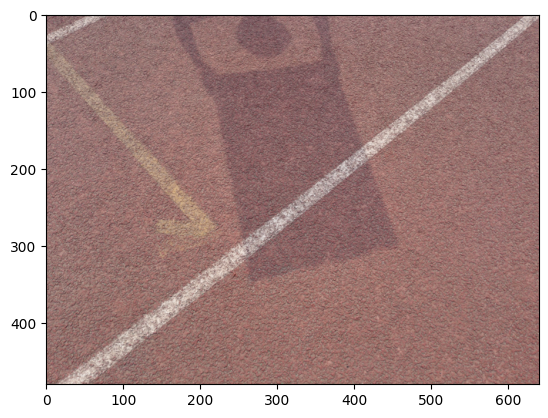

In [92]:
image_path = "../Images/image16.png"
image = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
plt.imshow(image)

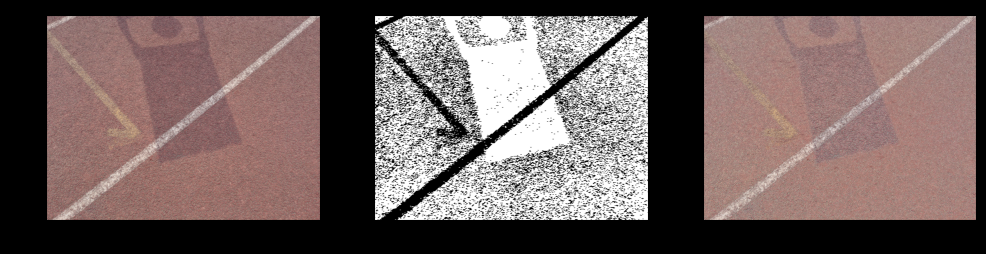

In [93]:
org_image, mask, image_clear = process_image_file(image=image,
                                                  itr=1,
                                                  method=3,
                                                  ab_threshold = -255,
                                                  lab_adjustment=False,
                                                  region_adjustment_kernel_size= 7,
                                                  shadow_dilation_kernel_size = 13,
                                                  shadow_dilation_iteration = 5,
                                                  shadow_size_threshold = 1200,
                                                  save = False,
                                                  verbose = False,
                                                  plot_results=True)

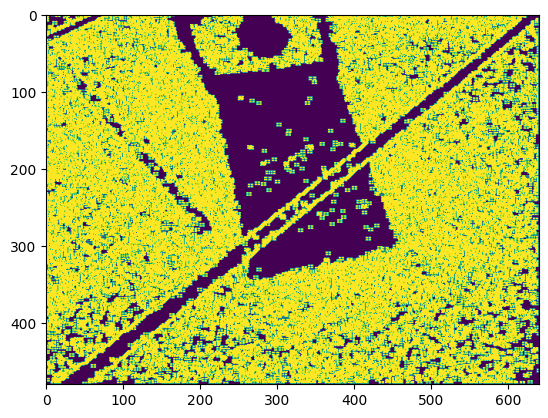

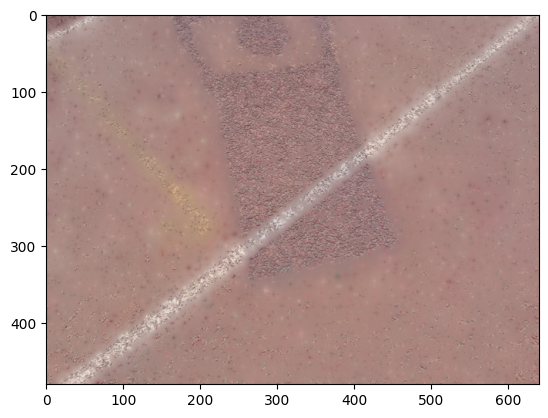

In [94]:
gX = cv2.Sobel(mask, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=5)
gY = cv2.Sobel(mask, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=5)

gX = cv2.convertScaleAbs(gX)
gY = cv2.convertScaleAbs(gY)

gXY = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)
plt.imshow(gXY)
plt.show()

plt.imshow(cv2.inpaint(image_clear,gXY,15,cv2.INPAINT_TELEA))
plt.show()